# 展示各個通道的RAW檔案(image = baboon)

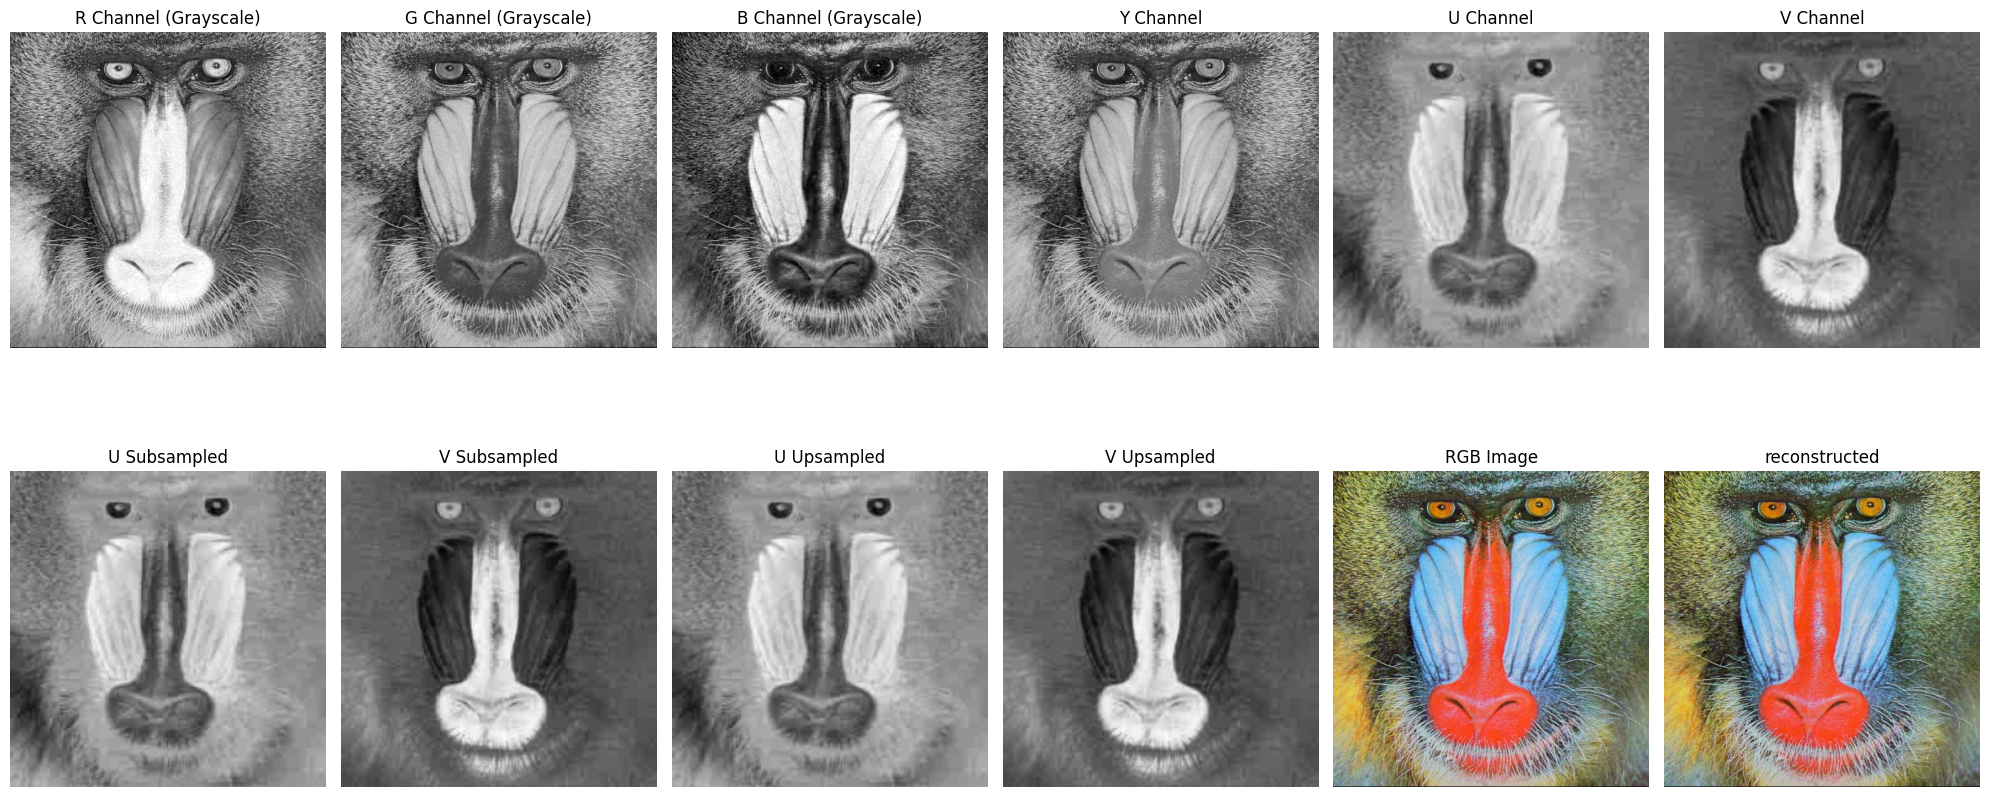

In [48]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ---- 基本參數設定 ----
width = 512
height = 512
input_filename = 'baboon.raw'  # 請換成實際的檔名 (512x512 RGB24bit)
channel_order = 'RGB'  # 根據實際情況設置 'RGB' 或 'BGR'

# ---- 讀取 RAW 檔案 (Sequential RGB 格式) ----
with open(input_filename, 'rb') as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint8)

# 將 R、G、B 通道分開（Sequential 格式）
R = raw_data[:width*height].reshape((height, width)).astype(np.float32)
G = raw_data[width*height:2*width*height].reshape((height, width)).astype(np.float32)
B = raw_data[2*width*height:].reshape((height, width)).astype(np.float32)

# 合併為 RGB 圖像
if channel_order == 'RGB':
    rgb_image = np.stack([R, G, B], axis=2).astype(np.uint8)
else:
    raise ValueError("Unsupported channel order")

# ---- RGB -> YUV (BT.601) ----
# Y, U, V range 在此為 0~255
Y = 0.299 * R + 0.587 * G + 0.114 * B
U = -0.14713 * R - 0.28886 * G + 0.436 * B + 128
V =  0.615 * R - 0.51499 * G - 0.10001 * B + 128

# 限制範圍為 0~255 並轉為 uint8
Y = np.clip(Y, 0, 255).astype(np.uint8)
U = np.clip(U, 0, 255).astype(np.uint8)
V = np.clip(V, 0, 255).astype(np.uint8)

# ---- U, V Downsampling (2x2) ----
U_sub = U[::2, ::2]  # size: 256 x 256
V_sub = V[::2, ::2]  # size: 256 x 256

# ---- U', V' Upsampling (Nearest Neighbor) ----
U_up = U_sub.repeat(2, axis=0).repeat(2, axis=1)
V_up = V_sub.repeat(2, axis=0).repeat(2, axis=1)

# ---- YUV -> RGB (重建 R'G'B') ----
Yf = Y.astype(np.float32)
Uf = U_up.astype(np.float32)
Vf = V_up.astype(np.float32)

# 使用 BT.601 逆轉換公式
R_rec = Yf + 1.13983 * (Vf - 128)
G_rec = Yf - 0.39465 * (Uf - 128) - 0.58060 * (Vf - 128)
B_rec = Yf + 2.03211 * (Uf - 128)

# 限制範圍為 0~255 並轉為 uint8
R_rec = np.clip(R_rec, 0, 255).astype(np.uint8)
G_rec = np.clip(G_rec, 0, 255).astype(np.uint8)
B_rec = np.clip(B_rec, 0, 255).astype(np.uint8)

# 合併為重建的 RGB 圖像
rgb_reconstructed = np.stack([R_rec, G_rec, B_rec], axis=2)

# ---- 在 Jupyter Notebook 中橫向排列展示圖片 ----
def display_images_in_two_rows(images, titles, fig_size=(20, 10)):
    """
    將多張圖片分為兩排排列展示
    :param images: 圖片列表，每張為 numpy array 格式
    :param titles: 標題列表，對應每張圖片
    :param fig_size: 整體圖表大小
    """
    num_images = len(images)
    num_cols = (num_images + 1) // 2  # 每排的圖片數量（向上取整）
    plt.figure(figsize=fig_size)
    for i, (image, title) in enumerate(zip(images, titles)):
        # 設定為兩行，每行 num_cols 張圖片
        plt.subplot(2, num_cols, i + 1)
        if len(image.shape) == 3:  # RGB 圖像
            plt.imshow(image)
        else:  # 灰階圖像
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()  # 自動調整間距
    plt.show()


images = [R, G, B, Y, U, V, U_sub, V_sub, U_up, V_up, rgb_image, rgb_reconstructed]
titles = [
    "R Channel (Grayscale)", "G Channel (Grayscale)", "B Channel (Grayscale)",
    "Y Channel", "U Channel", "V Channel","U Subsampled", 
    "V Subsampled", "U Upsampled", "V Upsampled","RGB Image","reconstructed"
]

# 使用修改後的函式展示圖片
display_images_in_two_rows(images, titles, fig_size=(20, 10))


# PSNR、MSE結果分析

In [49]:
import math
import numpy as np
import matplotlib.pyplot as plt

# ---- 計算均方誤差 (MSE) ----
def calculate_mse(image1, image2):
    """
    計算兩張圖片之間的均方誤差 (MSE)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :return: MSE 值
    """
    return np.mean((image1.astype(np.float32) - image2.astype(np.float32)) ** 2)

# ---- 計算 PSNR ----
def calculate_psnr(image1, image2, max_value=255.0):
    """
    計算兩張圖片之間的峰值訊噪比 (PSNR)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :param max_value: 圖片的最大可能值 (通常為 255)
    :return: PSNR 值
    """
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')  # 若 MSE 為 0，PSNR 無限大
    psnr = 10 * math.log10((max_value ** 2) / mse)
    return psnr

# ---- 輸出 MSE 和 PSNR 結果 ----
def print_mse_psnr():
    # 計算 R, G, B 通道的 MSE 和 PSNR
    mse_r = calculate_mse(R, R_rec)
    mse_g = calculate_mse(G, G_rec)
    mse_b = calculate_mse(B, B_rec)
    mse_rgb = calculate_mse(rgb_image, rgb_reconstructed)

    psnr_r = calculate_psnr(R, R_rec)
    psnr_g = calculate_psnr(G, G_rec)
    psnr_b = calculate_psnr(B, B_rec)
    psnr_rgb = calculate_psnr(rgb_image, rgb_reconstructed)

    # 計算 U 和 V 通道的 MSE 和 PSNR
    mse_u = calculate_mse(U, U_up)
    mse_v = calculate_mse(V, V_up)
    psnr_u = calculate_psnr(U, U_up)
    psnr_v = calculate_psnr(V, V_up)

    # ---- 輸出結果 ----
    print("\n=== MSE 計算結果 ===")
    print(f"R Channel MSE: {mse_r:.4f}")
    print(f"G Channel MSE: {mse_g:.4f}")
    print(f"B Channel MSE: {mse_b:.4f}")
    print(f"RGB Image MSE: {mse_rgb:.4f}")
    print(f"U Channel MSE (vs Upsampled): {mse_u:.4f}")
    print(f"V Channel MSE (vs Upsampled): {mse_v:.4f}")

    print("\n=== PSNR 計算結果 ===")
    print(f"R Channel PSNR: {psnr_r:.2f} dB")
    print(f"G Channel PSNR: {psnr_g:.2f} dB")
    print(f"B Channel PSNR: {psnr_b:.2f} dB")
    print(f"RGB Image PSNR: {psnr_rgb:.2f} dB")
    print(f"U Channel PSNR (vs Upsampled): {psnr_u:.2f} dB")
    print(f"V Channel PSNR (vs Upsampled): {psnr_v:.2f} dB")

# ---- 輸出 MSE 和 PSNR ----
print_mse_psnr()



=== MSE 計算結果 ===
R Channel MSE: 11.3667
G Channel MSE: 1.9708
B Channel MSE: 15.6804
RGB Image MSE: 9.6726
U Channel MSE (vs Upsampled): 2.9591
V Channel MSE (vs Upsampled): 7.0017

=== PSNR 計算結果 ===
R Channel PSNR: 37.57 dB
G Channel PSNR: 45.18 dB
B Channel PSNR: 36.18 dB
RGB Image PSNR: 38.28 dB
U Channel PSNR (vs Upsampled): 43.42 dB
V Channel PSNR (vs Upsampled): 39.68 dB


# 展示各個通道的RAW檔案(image = lena)

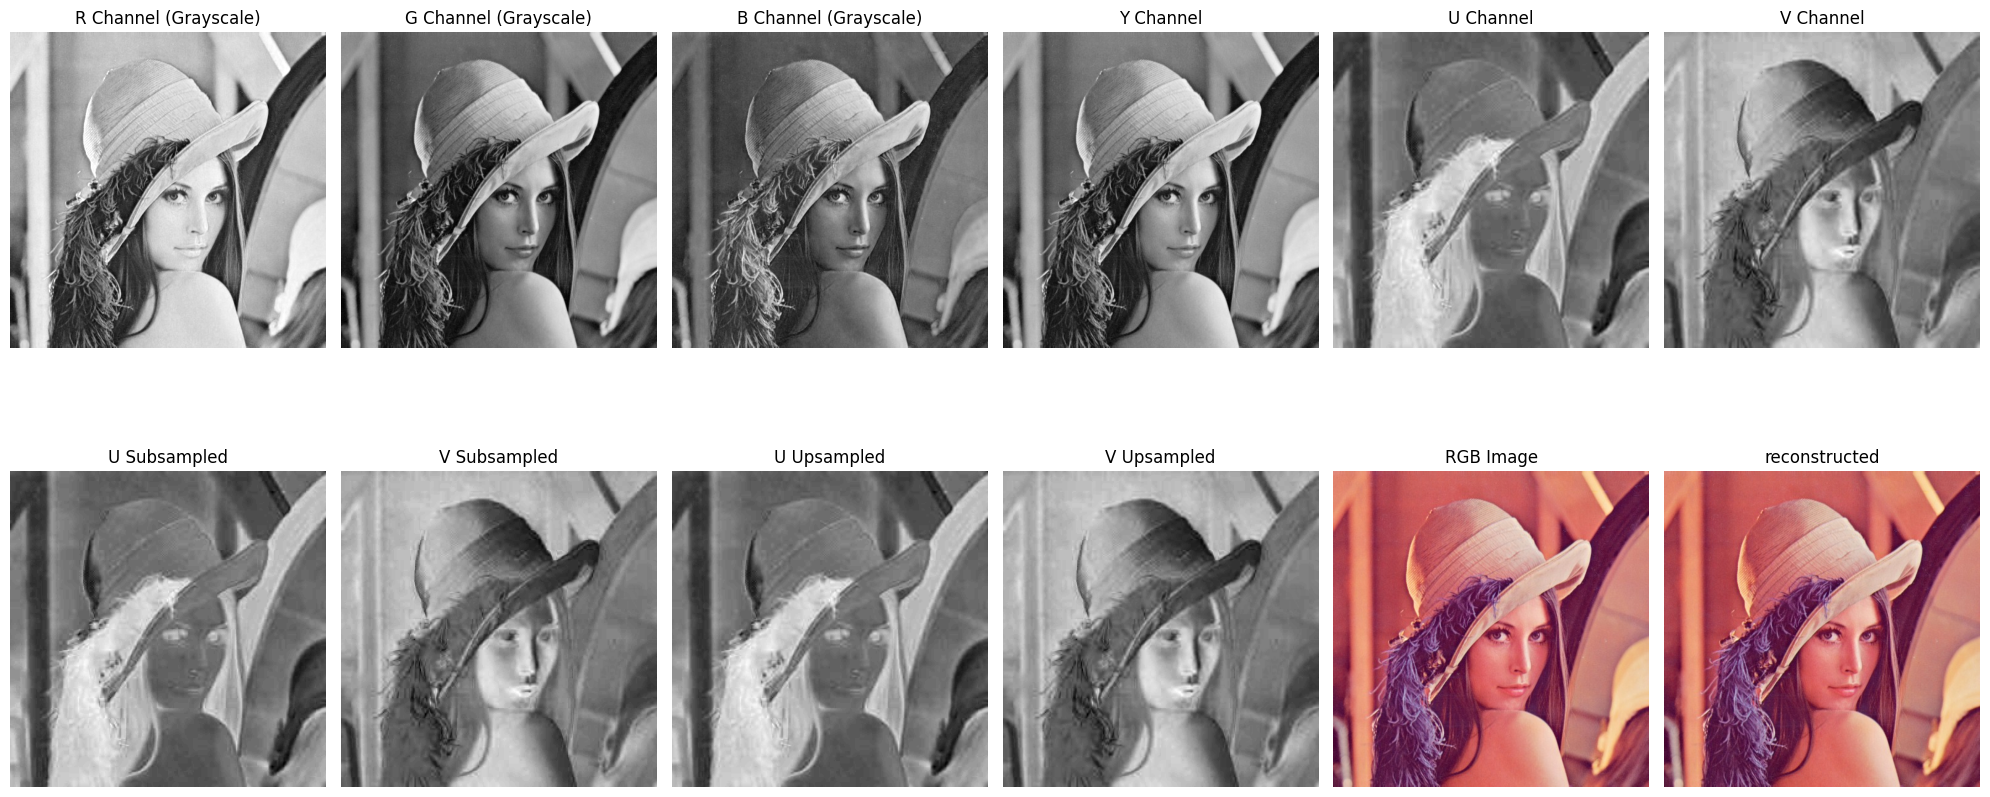

In [50]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ---- 基本參數設定 ----
width = 512
height = 512
input_filename = 'lena.raw'  # (512x512 RGB24bit)
channel_order = 'RGB'  # 根據實際情況設置 'RGB' 或 'BGR'

# ---- 讀取 RAW 檔案 (Sequential RGB 格式) ----
with open(input_filename, 'rb') as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint8)

# 將 R、G、B 通道分開（Sequential 格式）
R = raw_data[:width*height].reshape((height, width)).astype(np.float32)
G = raw_data[width*height:2*width*height].reshape((height, width)).astype(np.float32)
B = raw_data[2*width*height:].reshape((height, width)).astype(np.float32)

# 合併為 RGB 圖像
if channel_order == 'RGB':
    rgb_image = np.stack([R, G, B], axis=2).astype(np.uint8)
elif channel_order == 'BGR':
    rgb_image = np.stack([B, G, R], axis=2).astype(np.uint8)
else:
    raise ValueError("Unsupported channel order")

# ---- RGB -> YUV (BT.601) ----
# Y, U, V range 在此為 0~255
Y = 0.299 * R + 0.587 * G + 0.114 * B
U = -0.14713 * R - 0.28886 * G + 0.436 * B + 128
V =  0.615 * R - 0.51499 * G - 0.10001 * B + 128

# 限制範圍為 0~255 並轉為 uint8
Y = np.clip(Y, 0, 255).astype(np.uint8)
U = np.clip(U, 0, 255).astype(np.uint8)
V = np.clip(V, 0, 255).astype(np.uint8)

# ---- U, V Downsampling (2x2) ----
U_sub = U[::2, ::2]  # size: 256 x 256
V_sub = V[::2, ::2]  # size: 256 x 256

# ---- U', V' Upsampling (Nearest Neighbor) ----
U_up = U_sub.repeat(2, axis=0).repeat(2, axis=1)
V_up = V_sub.repeat(2, axis=0).repeat(2, axis=1)

# ---- YUV -> RGB (重建 R'G'B') ----
Yf = Y.astype(np.float32)
Uf = U_up.astype(np.float32)
Vf = V_up.astype(np.float32)

# 使用 BT.601 逆轉換公式
R_rec = Yf + 1.13983 * (Vf - 128)
G_rec = Yf - 0.39465 * (Uf - 128) - 0.58060 * (Vf - 128)
B_rec = Yf + 2.03211 * (Uf - 128)

# 限制範圍為 0~255 並轉為 uint8
R_rec = np.clip(R_rec, 0, 255).astype(np.uint8)
G_rec = np.clip(G_rec, 0, 255).astype(np.uint8)
B_rec = np.clip(B_rec, 0, 255).astype(np.uint8)

# 合併為重建的 RGB 圖像
rgb_reconstructed = np.stack([R_rec, G_rec, B_rec], axis=2)

# ---- 在 Jupyter Notebook 中橫向排列展示圖片 ----
def display_images_in_two_rows(images, titles, fig_size=(20, 10)):
    """
    將多張圖片分為兩排排列展示
    :param images: 圖片列表，每張為 numpy array 格式
    :param titles: 標題列表，對應每張圖片
    :param fig_size: 整體圖表大小
    """
    num_images = len(images)
    num_cols = (num_images + 1) // 2  # 每排的圖片數量（向上取整）
    plt.figure(figsize=fig_size)
    for i, (image, title) in enumerate(zip(images, titles)):
        # 設定為兩行，每行 num_cols 張圖片
        plt.subplot(2, num_cols, i + 1)
        if len(image.shape) == 3:  # RGB 圖像
            plt.imshow(image)
        else:  # 灰階圖像
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()  # 自動調整間距
    plt.show()


images = [R, G, B, Y, U, V, U_sub, V_sub, U_up, V_up, rgb_image, rgb_reconstructed]
titles = [
    "R Channel (Grayscale)", "G Channel (Grayscale)", "B Channel (Grayscale)",
    "Y Channel", "U Channel", "V Channel","U Subsampled", 
    "V Subsampled", "U Upsampled", "V Upsampled","RGB Image","reconstructed"
]

# 使用修改後的函式展示圖片
display_images_in_two_rows(images, titles, fig_size=(20, 10))


In [51]:
import math
import numpy as np
import matplotlib.pyplot as plt

# ---- 計算均方誤差 (MSE) ----
def calculate_mse(image1, image2):
    """
    計算兩張圖片之間的均方誤差 (MSE)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :return: MSE 值
    """
    return np.mean((image1.astype(np.float32) - image2.astype(np.float32)) ** 2)

# ---- 計算 PSNR ----
def calculate_psnr(image1, image2, max_value=255.0):
    """
    計算兩張圖片之間的峰值訊噪比 (PSNR)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :param max_value: 圖片的最大可能值 (通常為 255)
    :return: PSNR 值
    """
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')  # 若 MSE 為 0，PSNR 無限大
    psnr = 10 * math.log10((max_value ** 2) / mse)
    return psnr

# ---- 輸出 MSE 和 PSNR 結果 ----
def print_mse_psnr():
    # 計算 R, G, B 通道的 MSE 和 PSNR
    mse_r = calculate_mse(R, R_rec)
    mse_g = calculate_mse(G, G_rec)
    mse_b = calculate_mse(B, B_rec)
    mse_rgb = calculate_mse(rgb_image, rgb_reconstructed)

    psnr_r = calculate_psnr(R, R_rec)
    psnr_g = calculate_psnr(G, G_rec)
    psnr_b = calculate_psnr(B, B_rec)
    psnr_rgb = calculate_psnr(rgb_image, rgb_reconstructed)

    # 計算 U 和 V 通道的 MSE 和 PSNR
    mse_u = calculate_mse(U, U_up)
    mse_v = calculate_mse(V, V_up)
    psnr_u = calculate_psnr(U, U_up)
    psnr_v = calculate_psnr(V, V_up)

    # ---- 輸出結果 ----
    print("\n=== MSE 計算結果 ===")
    print(f"R Channel MSE: {mse_r:.4f}")
    print(f"G Channel MSE: {mse_g:.4f}")
    print(f"B Channel MSE: {mse_b:.4f}")
    print(f"RGB Image MSE: {mse_rgb:.4f}")
    print(f"U Channel MSE (vs Upsampled): {mse_u:.4f}")
    print(f"V Channel MSE (vs Upsampled): {mse_v:.4f}")

    print("\n=== PSNR 計算結果 ===")
    print(f"R Channel PSNR: {psnr_r:.2f} dB")
    print(f"G Channel PSNR: {psnr_g:.2f} dB")
    print(f"B Channel PSNR: {psnr_b:.2f} dB")
    print(f"RGB Image PSNR: {psnr_rgb:.2f} dB")
    print(f"U Channel PSNR (vs Upsampled): {psnr_u:.2f} dB")
    print(f"V Channel PSNR (vs Upsampled): {psnr_v:.2f} dB")

# ---- 輸出 MSE 和 PSNR ----
print_mse_psnr()



=== MSE 計算結果 ===
R Channel MSE: 5.5029
G Channel MSE: 1.3361
B Channel MSE: 9.5978
RGB Image MSE: 5.4789
U Channel MSE (vs Upsampled): 1.3155
V Channel MSE (vs Upsampled): 2.4154

=== PSNR 計算結果 ===
R Channel PSNR: 40.72 dB
G Channel PSNR: 46.87 dB
B Channel PSNR: 38.31 dB
RGB Image PSNR: 40.74 dB
U Channel PSNR (vs Upsampled): 46.94 dB
V Channel PSNR (vs Upsampled): 44.30 dB


# 展示各個通道的RAW檔案(image = Hw_image_1)

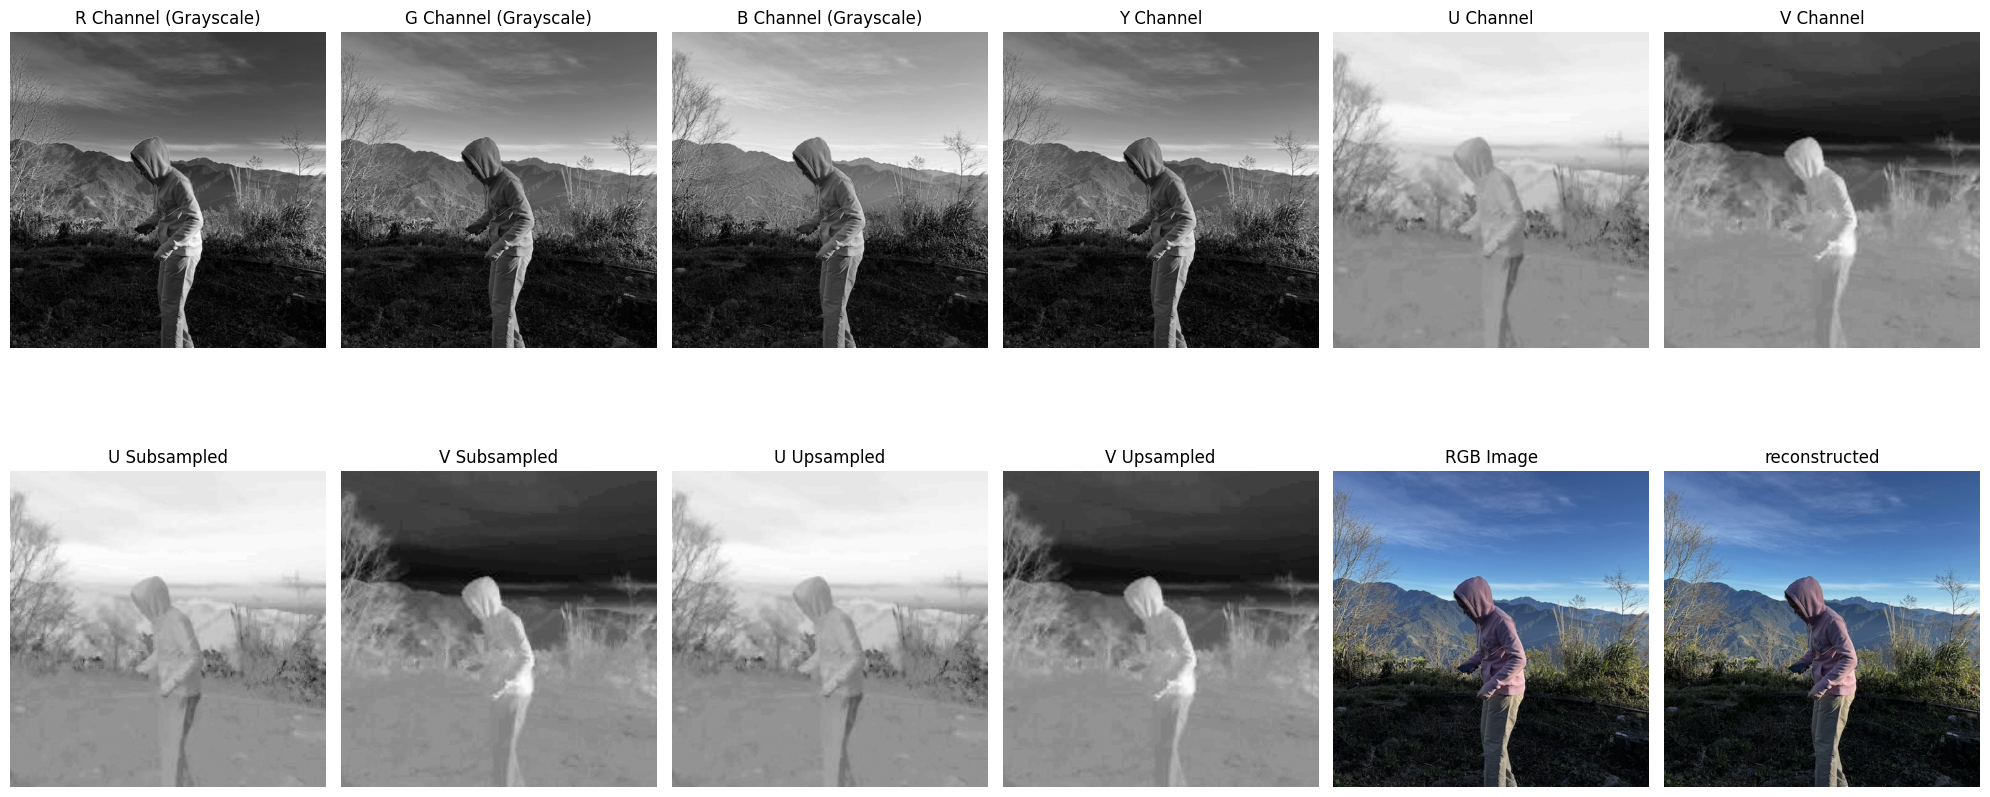

In [52]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ---- 基本參數設定 ----
width = 512
height = 512
input_filename = 'Hw_image_1.raw'  # (512x512 RGB24bit)
channel_order = 'RGB'  # 根據實際情況設置 'RGB' 或 'BGR'

# ---- 讀取 RAW 檔案 (Sequential RGB 格式) ----
with open(input_filename, 'rb') as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint8)

# 將 R、G、B 通道分開（Sequential 格式）
R = raw_data[:width*height].reshape((height, width)).astype(np.float32)
G = raw_data[width*height:2*width*height].reshape((height, width)).astype(np.float32)
B = raw_data[2*width*height:].reshape((height, width)).astype(np.float32)

# 合併為 RGB 圖像
if channel_order == 'RGB':
    rgb_image = np.stack([R, G, B], axis=2).astype(np.uint8)
elif channel_order == 'BGR':
    rgb_image = np.stack([B, G, R], axis=2).astype(np.uint8)
else:
    raise ValueError("Unsupported channel order")

# ---- RGB -> YUV (BT.601) ----
# Y, U, V range 在此為 0~255
Y = 0.299 * R + 0.587 * G + 0.114 * B
U = -0.14713 * R - 0.28886 * G + 0.436 * B + 128
V =  0.615 * R - 0.51499 * G - 0.10001 * B + 128

# 限制範圍為 0~255 並轉為 uint8
Y = np.clip(Y, 0, 255).astype(np.uint8)
U = np.clip(U, 0, 255).astype(np.uint8)
V = np.clip(V, 0, 255).astype(np.uint8)

# ---- U, V Downsampling (2x2) ----
U_sub = U[::2, ::2]  # size: 256 x 256
V_sub = V[::2, ::2]  # size: 256 x 256

# ---- U', V' Upsampling (Nearest Neighbor) ----
U_up = U_sub.repeat(2, axis=0).repeat(2, axis=1)
V_up = V_sub.repeat(2, axis=0).repeat(2, axis=1)

# ---- YUV -> RGB (重建 R'G'B') ----
Yf = Y.astype(np.float32)
Uf = U_up.astype(np.float32)
Vf = V_up.astype(np.float32)

# 使用 BT.601 逆轉換公式
R_rec = Yf + 1.13983 * (Vf - 128)
G_rec = Yf - 0.39465 * (Uf - 128) - 0.58060 * (Vf - 128)
B_rec = Yf + 2.03211 * (Uf - 128)

# 限制範圍為 0~255 並轉為 uint8
R_rec = np.clip(R_rec, 0, 255).astype(np.uint8)
G_rec = np.clip(G_rec, 0, 255).astype(np.uint8)
B_rec = np.clip(B_rec, 0, 255).astype(np.uint8)

# 合併為重建的 RGB 圖像
rgb_reconstructed = np.stack([R_rec, G_rec, B_rec], axis=2)

# ---- 在 Jupyter Notebook 中橫向排列展示圖片 ----
def display_images_in_two_rows(images, titles, fig_size=(20, 10)):
    """
    將多張圖片分為兩排排列展示
    :param images: 圖片列表，每張為 numpy array 格式
    :param titles: 標題列表，對應每張圖片
    :param fig_size: 整體圖表大小
    """
    num_images = len(images)
    num_cols = (num_images + 1) // 2  # 每排的圖片數量（向上取整）
    plt.figure(figsize=fig_size)
    for i, (image, title) in enumerate(zip(images, titles)):
        # 設定為兩行，每行 num_cols 張圖片
        plt.subplot(2, num_cols, i + 1)
        if len(image.shape) == 3:  # RGB 圖像
            plt.imshow(image)
        else:  # 灰階圖像
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()  # 自動調整間距
    plt.show()


images = [R, G, B, Y, U, V, U_sub, V_sub, U_up, V_up, rgb_image, rgb_reconstructed]
titles = [
    "R Channel (Grayscale)", "G Channel (Grayscale)", "B Channel (Grayscale)",
    "Y Channel", "U Channel", "V Channel","U Subsampled", 
    "V Subsampled", "U Upsampled", "V Upsampled","RGB Image","reconstructed"
]

# 使用修改後的函式展示圖片
display_images_in_two_rows(images, titles, fig_size=(20, 10))


In [53]:
import math
import numpy as np
import matplotlib.pyplot as plt

# ---- 計算均方誤差 (MSE) ----
def calculate_mse(image1, image2):
    """
    計算兩張圖片之間的均方誤差 (MSE)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :return: MSE 值
    """
    return np.mean((image1.astype(np.float32) - image2.astype(np.float32)) ** 2)

# ---- 計算 PSNR ----
def calculate_psnr(image1, image2, max_value=255.0):
    """
    計算兩張圖片之間的峰值訊噪比 (PSNR)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :param max_value: 圖片的最大可能值 (通常為 255)
    :return: PSNR 值
    """
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')  # 若 MSE 為 0，PSNR 無限大
    psnr = 10 * math.log10((max_value ** 2) / mse)
    return psnr

# ---- 輸出 MSE 和 PSNR 結果 ----
def print_mse_psnr():
    # 計算 R, G, B 通道的 MSE 和 PSNR
    mse_r = calculate_mse(R, R_rec)
    mse_g = calculate_mse(G, G_rec)
    mse_b = calculate_mse(B, B_rec)
    mse_rgb = calculate_mse(rgb_image, rgb_reconstructed)

    psnr_r = calculate_psnr(R, R_rec)
    psnr_g = calculate_psnr(G, G_rec)
    psnr_b = calculate_psnr(B, B_rec)
    psnr_rgb = calculate_psnr(rgb_image, rgb_reconstructed)

    # 計算 U 和 V 通道的 MSE 和 PSNR
    mse_u = calculate_mse(U, U_up)
    mse_v = calculate_mse(V, V_up)
    psnr_u = calculate_psnr(U, U_up)
    psnr_v = calculate_psnr(V, V_up)

    # ---- 輸出結果 ----
    print("\n=== MSE 計算結果 ===")
    print(f"R Channel MSE: {mse_r:.4f}")
    print(f"G Channel MSE: {mse_g:.4f}")
    print(f"B Channel MSE: {mse_b:.4f}")
    print(f"RGB Image MSE: {mse_rgb:.4f}")
    print(f"U Channel MSE (vs Upsampled): {mse_u:.4f}")
    print(f"V Channel MSE (vs Upsampled): {mse_v:.4f}")

    print("\n=== PSNR 計算結果 ===")
    print(f"R Channel PSNR: {psnr_r:.2f} dB")
    print(f"G Channel PSNR: {psnr_g:.2f} dB")
    print(f"B Channel PSNR: {psnr_b:.2f} dB")
    print(f"RGB Image PSNR: {psnr_rgb:.2f} dB")
    print(f"U Channel PSNR (vs Upsampled): {psnr_u:.2f} dB")
    print(f"V Channel PSNR (vs Upsampled): {psnr_v:.2f} dB")

# ---- 輸出 MSE 和 PSNR ----
print_mse_psnr()



=== MSE 計算結果 ===
R Channel MSE: 3.6959
G Channel MSE: 0.6825
B Channel MSE: 6.7380
RGB Image MSE: 3.7055
U Channel MSE (vs Upsampled): 0.8562
V Channel MSE (vs Upsampled): 0.7505

=== PSNR 計算結果 ===
R Channel PSNR: 42.45 dB
G Channel PSNR: 49.79 dB
B Channel PSNR: 39.85 dB
RGB Image PSNR: 42.44 dB
U Channel PSNR (vs Upsampled): 48.80 dB
V Channel PSNR (vs Upsampled): 49.38 dB


# 展示各個通道的RAW檔案(image = Hw_image_2)

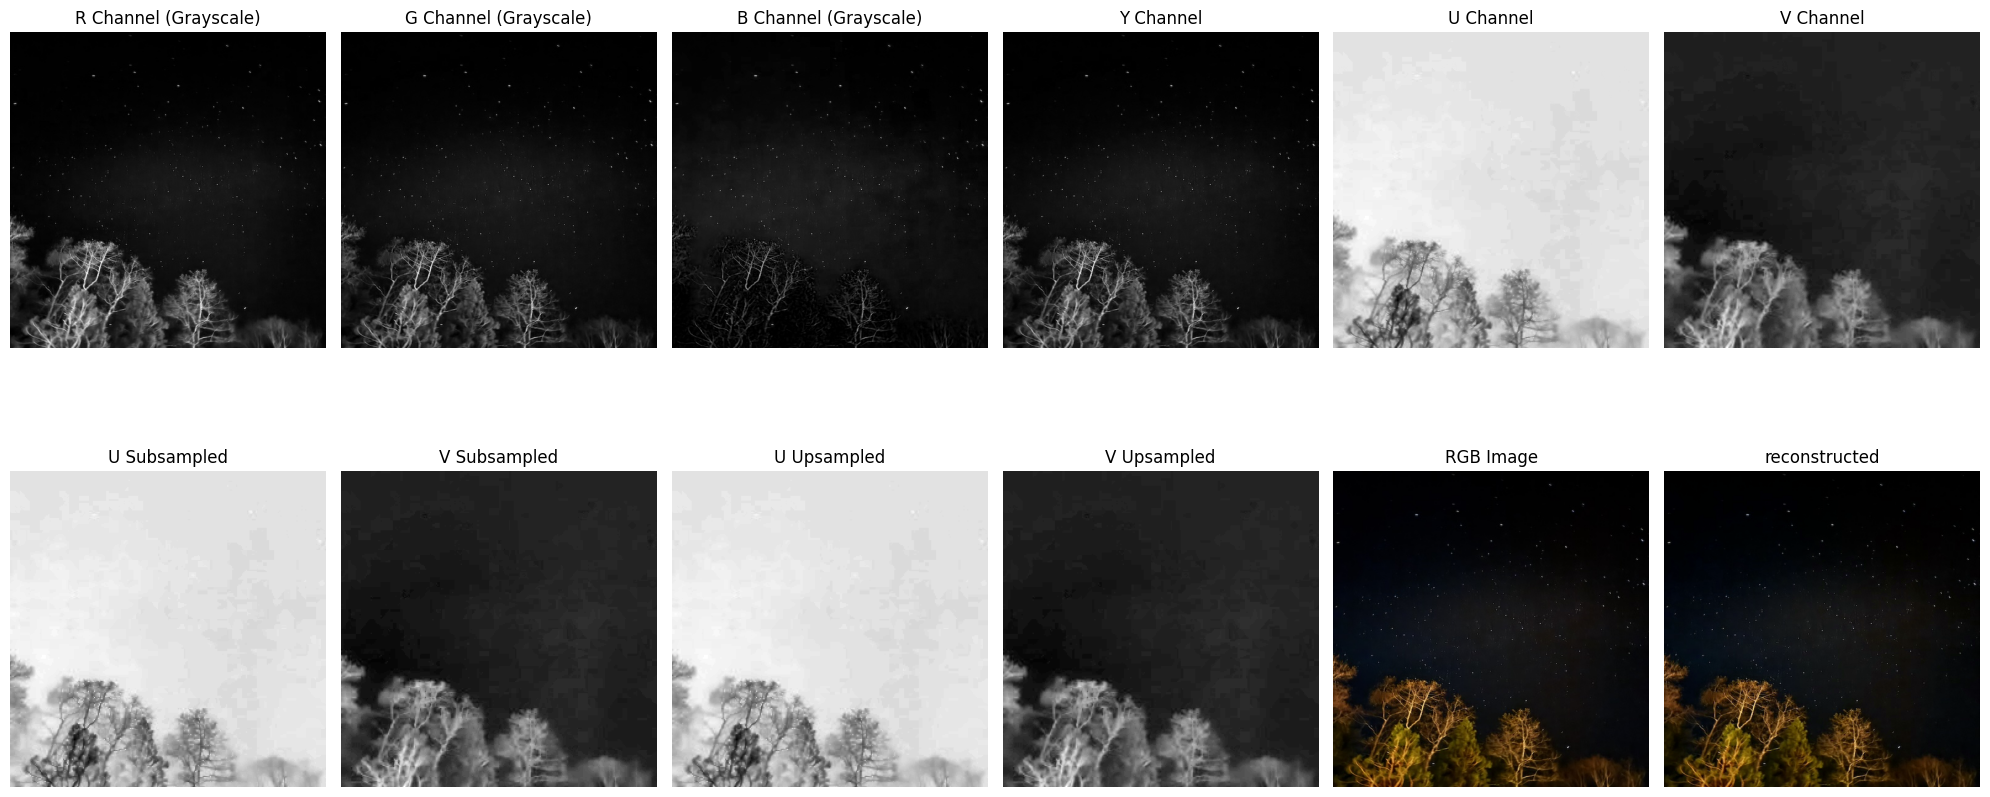

In [54]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ---- 基本參數設定 ----
width = 512
height = 512
input_filename = 'Hw_image_2.raw'  # (512x512 RGB24bit)
channel_order = 'RGB'  # 根據實際情況設置 'RGB' 或 'BGR'

# ---- 讀取 RAW 檔案 (Sequential RGB 格式) ----
with open(input_filename, 'rb') as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint8)

# 將 R、G、B 通道分開（Sequential 格式）
R = raw_data[:width*height].reshape((height, width)).astype(np.float32)
G = raw_data[width*height:2*width*height].reshape((height, width)).astype(np.float32)
B = raw_data[2*width*height:].reshape((height, width)).astype(np.float32)

# 合併為 RGB 圖像
if channel_order == 'RGB':
    rgb_image = np.stack([R, G, B], axis=2).astype(np.uint8)
elif channel_order == 'BGR':
    rgb_image = np.stack([B, G, R], axis=2).astype(np.uint8)
else:
    raise ValueError("Unsupported channel order")

# ---- RGB -> YUV (BT.601) ----
# Y, U, V range 在此為 0~255
Y = 0.299 * R + 0.587 * G + 0.114 * B
U = -0.14713 * R - 0.28886 * G + 0.436 * B + 128
V =  0.615 * R - 0.51499 * G - 0.10001 * B + 128

# 限制範圍為 0~255 並轉為 uint8
Y = np.clip(Y, 0, 255).astype(np.uint8)
U = np.clip(U, 0, 255).astype(np.uint8)
V = np.clip(V, 0, 255).astype(np.uint8)

# ---- U, V Downsampling (2x2) ----
U_sub = U[::2, ::2]  # size: 256 x 256
V_sub = V[::2, ::2]  # size: 256 x 256

# ---- U', V' Upsampling (Nearest Neighbor) ----
U_up = U_sub.repeat(2, axis=0).repeat(2, axis=1)
V_up = V_sub.repeat(2, axis=0).repeat(2, axis=1)

# ---- YUV -> RGB (重建 R'G'B') ----
Yf = Y.astype(np.float32)
Uf = U_up.astype(np.float32)
Vf = V_up.astype(np.float32)

# 使用 BT.601 逆轉換公式
R_rec = Yf + 1.13983 * (Vf - 128)
G_rec = Yf - 0.39465 * (Uf - 128) - 0.58060 * (Vf - 128)
B_rec = Yf + 2.03211 * (Uf - 128)

# 限制範圍為 0~255 並轉為 uint8
R_rec = np.clip(R_rec, 0, 255).astype(np.uint8)
G_rec = np.clip(G_rec, 0, 255).astype(np.uint8)
B_rec = np.clip(B_rec, 0, 255).astype(np.uint8)

# 合併為重建的 RGB 圖像
rgb_reconstructed = np.stack([R_rec, G_rec, B_rec], axis=2)

# ---- 在 Jupyter Notebook 中橫向排列展示圖片 ----
def display_images_in_two_rows(images, titles, fig_size=(20, 10)):
    """
    將多張圖片分為兩排排列展示
    :param images: 圖片列表，每張為 numpy array 格式
    :param titles: 標題列表，對應每張圖片
    :param fig_size: 整體圖表大小
    """
    num_images = len(images)
    num_cols = (num_images + 1) // 2  # 每排的圖片數量（向上取整）
    plt.figure(figsize=fig_size)
    for i, (image, title) in enumerate(zip(images, titles)):
        # 設定為兩行，每行 num_cols 張圖片
        plt.subplot(2, num_cols, i + 1)
        if len(image.shape) == 3:  # RGB 圖像
            plt.imshow(image)
        else:  # 灰階圖像
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()  # 自動調整間距
    plt.show()


images = [R, G, B, Y, U, V, U_sub, V_sub, U_up, V_up, rgb_image, rgb_reconstructed]
titles = [
    "R Channel (Grayscale)", "G Channel (Grayscale)", "B Channel (Grayscale)",
    "Y Channel", "U Channel", "V Channel","U Subsampled", 
    "V Subsampled", "U Upsampled", "V Upsampled","RGB Image","reconstructed"
]

# 使用修改後的函式展示圖片
display_images_in_two_rows(images, titles, fig_size=(20, 10))


In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt

# ---- 計算均方誤差 (MSE) ----
def calculate_mse(image1, image2):
    """
    計算兩張圖片之間的均方誤差 (MSE)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :return: MSE 值
    """
    return np.mean((image1.astype(np.float32) - image2.astype(np.float32)) ** 2)

# ---- 計算 PSNR ----
def calculate_psnr(image1, image2, max_value=255.0):
    """
    計算兩張圖片之間的峰值訊噪比 (PSNR)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :param max_value: 圖片的最大可能值 (通常為 255)
    :return: PSNR 值
    """
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')  # 若 MSE 為 0，PSNR 無限大
    psnr = 10 * math.log10((max_value ** 2) / mse)
    return psnr

# ---- 輸出 MSE 和 PSNR 結果 ----
def print_mse_psnr():
    # 計算 R, G, B 通道的 MSE 和 PSNR
    mse_r = calculate_mse(R, R_rec)
    mse_g = calculate_mse(G, G_rec)
    mse_b = calculate_mse(B, B_rec)
    mse_rgb = calculate_mse(rgb_image, rgb_reconstructed)

    psnr_r = calculate_psnr(R, R_rec)
    psnr_g = calculate_psnr(G, G_rec)
    psnr_b = calculate_psnr(B, B_rec)
    psnr_rgb = calculate_psnr(rgb_image, rgb_reconstructed)

    # 計算 U 和 V 通道的 MSE 和 PSNR
    mse_u = calculate_mse(U, U_up)
    mse_v = calculate_mse(V, V_up)
    psnr_u = calculate_psnr(U, U_up)
    psnr_v = calculate_psnr(V, V_up)

    # ---- 輸出結果 ----
    print("\n=== MSE 計算結果 ===")
    print(f"R Channel MSE: {mse_r:.4f}")
    print(f"G Channel MSE: {mse_g:.4f}")
    print(f"B Channel MSE: {mse_b:.4f}")
    print(f"RGB Image MSE: {mse_rgb:.4f}")
    print(f"U Channel MSE (vs Upsampled): {mse_u:.4f}")
    print(f"V Channel MSE (vs Upsampled): {mse_v:.4f}")

    print("\n=== PSNR 計算結果 ===")
    print(f"R Channel PSNR: {psnr_r:.2f} dB")
    print(f"G Channel PSNR: {psnr_g:.2f} dB")
    print(f"B Channel PSNR: {psnr_b:.2f} dB")
    print(f"RGB Image PSNR: {psnr_rgb:.2f} dB")
    print(f"U Channel PSNR (vs Upsampled): {psnr_u:.2f} dB")
    print(f"V Channel PSNR (vs Upsampled): {psnr_v:.2f} dB")

# ---- 輸出 MSE 和 PSNR ----
print_mse_psnr()



=== MSE 計算結果 ===
R Channel MSE: 3.0598
G Channel MSE: 0.4955
B Channel MSE: 6.0449
RGB Image MSE: 3.2001
U Channel MSE (vs Upsampled): 1.6265
V Channel MSE (vs Upsampled): 0.7612

=== PSNR 計算結果 ===
R Channel PSNR: 43.27 dB
G Channel PSNR: 51.18 dB
B Channel PSNR: 40.32 dB
RGB Image PSNR: 43.08 dB
U Channel PSNR (vs Upsampled): 46.02 dB
V Channel PSNR (vs Upsampled): 49.32 dB


# 額外實驗分析

RGB Image MSE: 3.7055
RGB Image PSNR: 42.44 dB


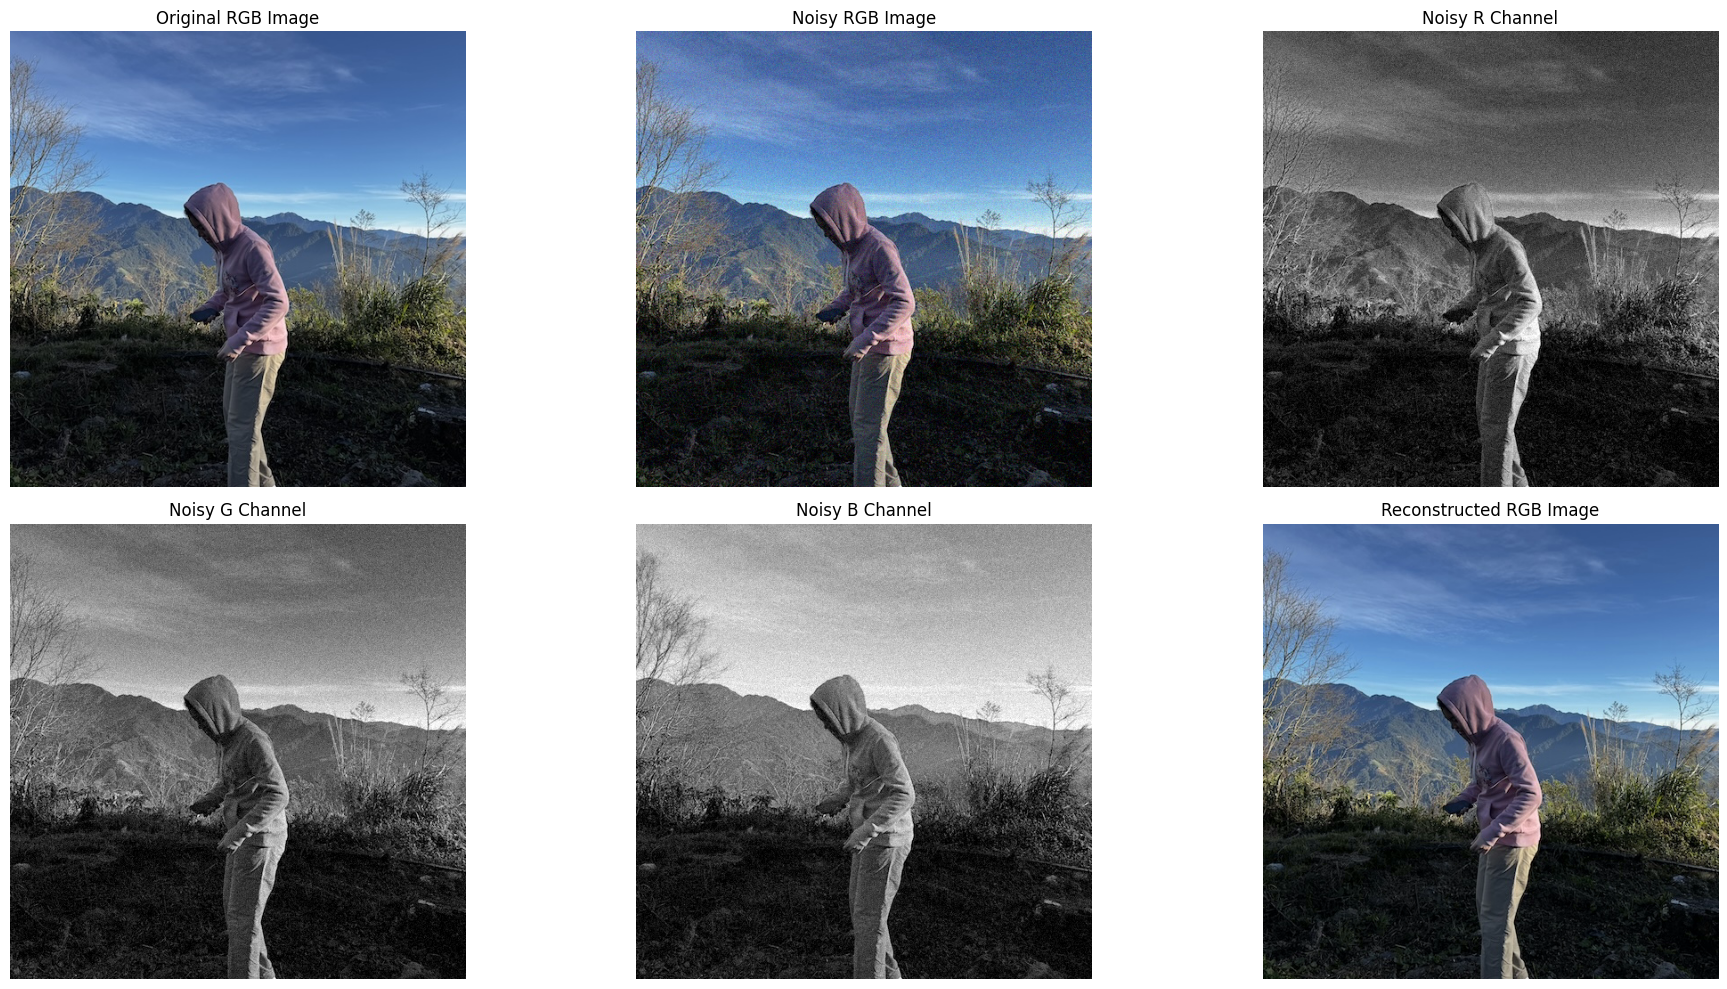

In [56]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math

# ---- 基本參數設定 ----
width = 512
height = 512
input_filename = 'Hw_image_1.raw'  # (512x512 RGB24bit)
channel_order = 'RGB'  # 根據實際情況設置 'RGB' 或 'BGR'

# ---- 讀取 RAW 檔案 (Sequential RGB 格式) ----
with open(input_filename, 'rb') as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint8)

# 將 R、G、B 通道分開（Sequential 格式）
R = raw_data[:width*height].reshape((height, width)).astype(np.float32)
G = raw_data[width*height:2*width*height].reshape((height, width)).astype(np.float32)
B = raw_data[2*width*height:].reshape((height, width)).astype(np.float32)

# 合併為 RGB 圖像
if channel_order == 'RGB':
    rgb_image = np.stack([R, G, B], axis=2).astype(np.uint8)
elif channel_order == 'BGR':
    rgb_image = np.stack([B, G, R], axis=2).astype(np.uint8)
else:
    raise ValueError("Unsupported channel order")

# ---- 增加高斯噪音 ----
def add_gaussian_noise(image, mean=0, std=10):
    """
    為圖像添加高斯噪音
    :param image: 原始圖像 (numpy array)
    :param mean: 高斯分布的均值
    :param std: 高斯分布的標準差
    :return: 添加噪音後的圖像
    """
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

# 為 R、G、B 通道分別添加高斯噪音
R_noisy = add_gaussian_noise(R)
G_noisy = add_gaussian_noise(G)
B_noisy = add_gaussian_noise(B)

# 合併噪音後的 RGB 圖像
rgb_noisy = np.stack([R_noisy, G_noisy, B_noisy], axis=2)

# ---- RGB -> YUV (BT.601) ----
# Y, U, V range 在此為 0~255
Y = 0.299 * R + 0.587 * G + 0.114 * B
U = -0.14713 * R - 0.28886 * G + 0.436 * B + 128
V =  0.615 * R - 0.51499 * G - 0.10001 * B + 128

# 限制範圍為 0~255 並轉為 uint8
Y = np.clip(Y, 0, 255).astype(np.uint8)
U = np.clip(U, 0, 255).astype(np.uint8)
V = np.clip(V, 0, 255).astype(np.uint8)

# ---- U, V Downsampling (2x2) ----
U_sub = U[::2, ::2]  # size: 256 x 256
V_sub = V[::2, ::2]  # size: 256 x 256

# ---- U', V' Upsampling (Nearest Neighbor) ----
U_up = U_sub.repeat(2, axis=0).repeat(2, axis=1)
V_up = V_sub.repeat(2, axis=0).repeat(2, axis=1)

# ---- YUV -> RGB (重建 R'G'B') ----
Yf = Y.astype(np.float32)
Uf = U_up.astype(np.float32)
Vf = V_up.astype(np.float32)

# 使用 BT.601 逆轉換公式
R_rec = Yf + 1.13983 * (Vf - 128)
G_rec = Yf - 0.39465 * (Uf - 128) - 0.58060 * (Vf - 128)
B_rec = Yf + 2.03211 * (Uf - 128)

# 限制範圍為 0~255 並轉為 uint8
R_rec = np.clip(R_rec, 0, 255).astype(np.uint8)
G_rec = np.clip(G_rec, 0, 255).astype(np.uint8)
B_rec = np.clip(B_rec, 0, 255).astype(np.uint8)

# 合併為重建的 RGB 圖像
rgb_reconstructed = np.stack([R_rec, G_rec, B_rec], axis=2)

# ---- 計算 MSE 和 PSNR ----
def calculate_mse(image1, image2):
    """
    計算兩張圖片之間的均方誤差 (MSE)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :return: MSE 值
    """
    return np.mean((image1.astype(np.float32) - image2.astype(np.float32)) ** 2)

def calculate_psnr(image1, image2, max_value=255.0):
    """
    計算兩張圖片之間的峰值訊噪比 (PSNR)
    :param image1: 原始圖片 (numpy array)
    :param image2: 重建圖片 (numpy array)
    :param max_value: 圖片的最大可能值 (通常為 255)
    :return: PSNR 值
    """
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')  # 若 MSE 為 0，PSNR 無限大
    psnr = 10 * math.log10((max_value ** 2) / mse)
    return psnr

# 計算 MSE 和 PSNR
mse_rgb = calculate_mse(rgb_image, rgb_reconstructed)
psnr_rgb = calculate_psnr(rgb_image, rgb_reconstructed)

print(f"RGB Image MSE: {mse_rgb:.4f}")
print(f"RGB Image PSNR: {psnr_rgb:.2f} dB")

# ---- 在 Jupyter Notebook 中橫向排列展示圖片 ----
def display_images_in_two_rows(images, titles, fig_size=(20, 10)):
    """
    將多張圖片分為兩排排列展示
    :param images: 圖片列表，每張為 numpy array 格式
    :param titles: 標題列表，對應每張圖片
    :param fig_size: 整體圖表大小
    """
    num_images = len(images)
    num_cols = (num_images + 1) // 2  # 每排的圖片數量（向上取整）
    plt.figure(figsize=fig_size)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(2, num_cols, i + 1)
        if len(image.shape) == 3:  # RGB 圖像
            plt.imshow(image)
        else:  # 灰階圖像
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()  # 自動調整間距
    plt.show()

images = [rgb_image, rgb_noisy, R_noisy, G_noisy, B_noisy, rgb_reconstructed]
titles = [
    "Original RGB Image", "Noisy RGB Image", "Noisy R Channel",
    "Noisy G Channel", "Noisy B Channel", "Reconstructed RGB Image"
]

# 使用函式展示圖片
display_images_in_two_rows(images, titles, fig_size=(20, 10))
